In [1]:
%matplotlib inline

import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
plt.switch_backend('agg')

if "./lib" not in sys.path:
    sys.path.append("./lib")
    
import plotting
from collections import deque, namedtuple
from readingFileEfficiently import *
import VOC2012_npz_files_writter
from DNN import *
from Agent import ObjLocaliser

/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


Instructions for updating:
Please switch to tf.train.get_global_step


/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading model checkpoint /home/mohammad/active localization/trained_on_cluster_final/cat_loss_test/checkpoints/model...

INFO:tensorflow:Restoring parameters from /home/mohammad/active localization/trained_on_cluster_final/cat_loss_test/checkpoints/model


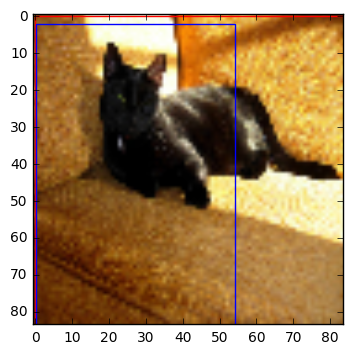

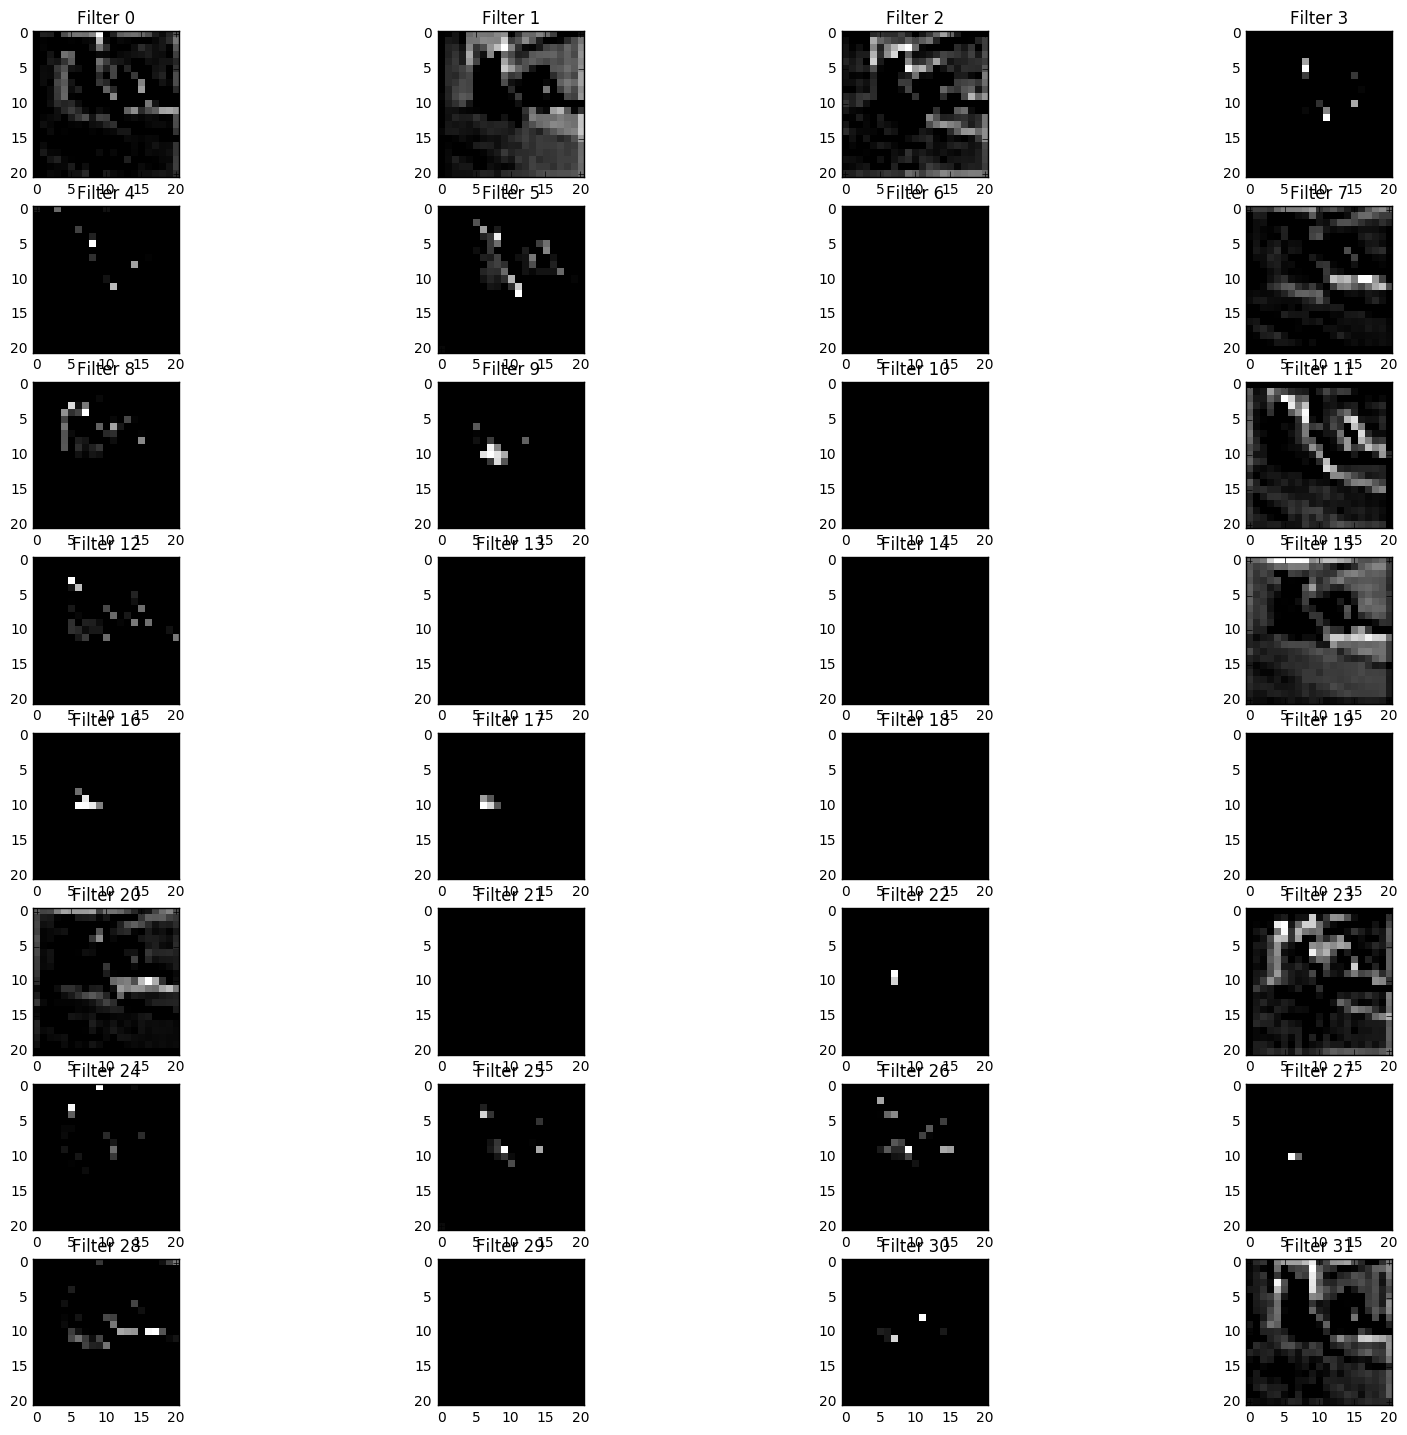

In [2]:

model_name = "cat_loss_test"


tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("/home/mohammad/active localization/trained_on_cluster_final/{}".format(model_name))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)

# State processor
state_processor = StateProcessor()



with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer()) 
    num_located = 0

    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    report_path = os.path.join(experiment_dir, "report")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(report_path):
        os.makedirs(report_path)
    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)

    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())


    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))
    


    im2 = np.array(Image.open('./input/2010_002531.jpg'))#train
    env = ObjLocaliser(np.array(im2),{'xmin':[1], 'xmax':[323], 'ymin':[9], 'ymax':[494]})
        
    
    # Save the current checkpoint
    saver.save(tf.get_default_session(), checkpoint_path)

    # Reset the environment
    env.Reset(np.array(im2))
    env.drawActions()
    state = env.wrapping()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    q_estimator.visulize_layers(sess, state.reshape((-1, 84, 84, 4)), "1")
